In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Validation.csv')

In [3]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [4]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

#'Hour', 'Day', and 'Month' created
for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31)
    df = add_cyclical_features(df, 'Month', 12)

In [5]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW']

# Applying the function to the datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Applying transformation to all datasets.
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)


y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']

In [7]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [8]:
# Checking the shape of X_train_poly before reshaping
print("Shape of X_train_poly:", X_train_poly.shape)

Shape of X_train_poly: (17516, 77)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=1, padding='same', input_shape=input_shape,
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Activation('relu'),
        Dropout(0.3),
        MaxPooling1D(pool_size=1),

        Conv1D(filters=32, kernel_size=1, padding='same',
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        MaxPooling1D(pool_size=1),

        LSTM(units=32, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.3),

        Dense(units=32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.3),

        Dense(units=1)
    ])

    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model


n_features = X_train_poly.shape[1]  # Number of features from the polynomial features
input_shape = (n_features, 1)

# Creating the model
cnn_lstm_model = create_cnn_lstm_model(input_shape)

# Reshaping data to fit the model's expected input
X_train_reshaped = X_train_poly.reshape((X_train_poly.shape[0], n_features, 1))
X_validation_reshaped = X_validation_poly.reshape((X_validation_poly.shape[0], n_features, 1))


In [ ]:
# Define path where the model is saved
model_path = '/content/drive/MyDrive/Saved_trained_models/cnn_lstm_hybrid_model_v3.h5'

# Setup EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Setup ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model with both EarlyStopping and ModelCheckpoint callbacks
history = cnn_lstm_model.fit(
    X_train_reshaped,
    y_train,
    validation_data=(X_validation_reshaped, y_validation),
    epochs=100,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/100
548/548 [==============================] - ETA: 0s - loss: 4974.6309
Epoch 1: val_loss improved from inf to 1967.09912, saving model to /content/drive/MyDrive/Saved_trained_models/cnn_lstm_hybrid_model_v3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


548/548 [==============================] - 28s 45ms/step - loss: 4974.6309 - val_loss: 1967.0991
Epoch 2/100
548/548 [==============================] - ETA: 0s - loss: 3074.3049
Epoch 2: val_loss improved from 1967.09912 to 642.37140, saving model to /content/drive/MyDrive/Saved_trained_models/cnn_lstm_hybrid_model_v3.h5
548/548 [==============================] - 22s 40ms/step - loss: 3074.3049 - val_loss: 642.3714
Epoch 3/100
547/548 [============================>.] - ETA: 0s - loss: 1618.0363
Epoch 3: val_loss improved from 642.37140 to 520.36707, saving model to /content/drive/MyDrive/Saved_trained_models/cnn_lstm_hybrid_model_v3.h5
548/548 [==============================] - 24s 44ms/step - loss: 1618.2103 - val_loss: 520.3671
Epoch 4/100
547/548 [============================>.] - ETA: 0s - loss: 1366.7552
Epoch 4: val_loss did not improve from 520.36707
548/548 [==============================] - 23s 43ms/step - loss: 1366.1301 - val_loss: 528.1703
Epoch 5/100
547/548 [=============

In [9]:
from tensorflow.keras.models import load_model
# Path where the model will be loaded
model_path = '/content/drive/MyDrive/Saved_trained_models/cnn_lstm_hybrid_model_v3.h5'

# Load the best saved model from the specified path
best_model = load_model(model_path)

In [11]:
# Reshaping test data
n_features = X_train_poly.shape[1]
X_test_reshaped = X_test_poly.reshape((X_test_poly.shape[0], n_features, 1))
input_shape = (n_features, 1)

# Reshaping data to fit the model's expected input
X_train_reshaped = X_train_poly.reshape((X_train_poly.shape[0], n_features, 1))
X_validation_reshaped = X_validation_poly.reshape((X_validation_poly.shape[0], n_features, 1))


# Generating predictions for the training, validation, and test sets
y_train_pred = best_model.predict(X_train_reshaped)
y_validation_pred = best_model.predict(X_validation_reshaped)
y_test_pred = best_model.predict(X_test_reshaped)
# Generating predictions for the training, validation, and test sets
y_train_pred = best_model.predict(X_train_reshaped)
y_validation_pred = best_model.predict(X_validation_reshaped)
y_test_pred = best_model.predict(X_test_reshaped)

# Calculating the evaluation metrics for the training set
train_mae, train_mape, train_smape, train_rmse = calculate_metrics(y_train, y_train_pred.flatten())
print(f'Train Set - MAE: {train_mae}, MAPE: {train_mape}, sMAPE: {train_smape}, RMSE: {train_rmse}')

# Calculating the evaluation metrics for the validation set
val_mae, val_mape, val_smape, val_rmse = calculate_metrics(y_validation, y_validation_pred.flatten())
print(f'Validation Set - MAE: {val_mae}, MAPE: {val_mape}, sMAPE: {val_smape}, RMSE: {val_rmse}')

# Calculating the evaluation metrics for the test set
test_mae, test_mape, test_smape, test_rmse = calculate_metrics(y_test, y_test_pred.flatten())
test_metrics = [test_mae, test_mape, test_smape, test_rmse]
print(f'Test Set - MAE: {test_mae}, MAPE: {test_mape}, sMAPE: {test_smape}, RMSE: {test_rmse}')


45/45 [==============================] - 0s 8ms/step
Train Set - MAE: 8.265590122952897, MAPE: 12.520682676436858, sMAPE: 13.099094105137274, RMSE: 18.5766461896924
Validation Set - MAE: 7.3608822253424355, MAPE: 15.195681475739468, sMAPE: 15.431861024052635, RMSE: 13.976599062416645
Test Set - MAE: 5.050679804381046, MAPE: 9.144023903865245, sMAPE: 10.29627474254416, RMSE: 8.30007693393354


In [12]:
print(f"The input {(n_features, 1)}" )

The input (77, 1)


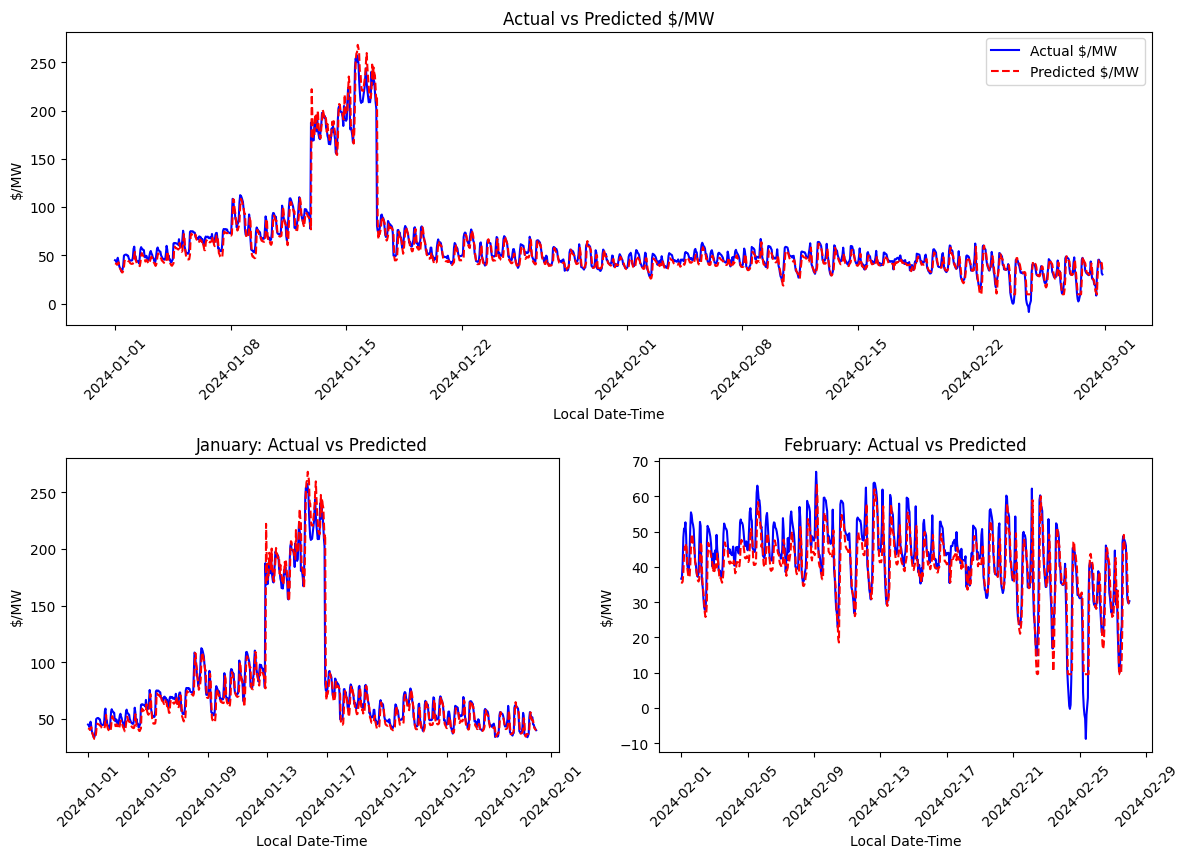

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

test_df_for_plotting = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

if len(test_local_time) > len(y_test_pred):
    test_local_time = test_local_time[:len(y_test_pred)]

# Converting 'test_local_time' to datetime
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = y_test_pred[is_january]

# Filter for February
february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = y_test_pred[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)

# Main plot spanning the first row
ax0 = plt.subplot(gs[0, :])
ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax0.plot(test_local_time, y_test_pred, label='Predicted $/MW', color='red', linestyle='--')
ax0.set_title('Actual vs Predicted $/MW')
ax0.set_xlabel('Local Date-Time')
ax0.set_ylabel('$/MW')
ax0.legend()
ax0.tick_params(axis='x', rotation=45)

# January subplot in the second row, first column
ax1 = plt.subplot(gs[1, 0])  # Bottom left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January: Actual vs Predicted')
ax1.set_xlabel('Local Date-Time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)

# February subplot in the second row, second column
ax2 = plt.subplot(gs[1, 1])  # Bottom right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February: Actual vs Predicted')
ax2.set_xlabel('Local Date-Time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

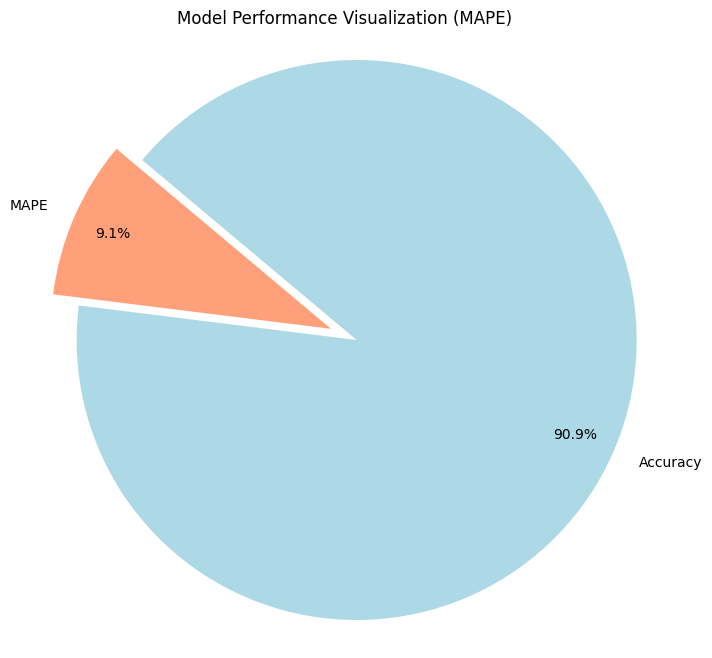

In [ ]:
import matplotlib.pyplot as plt


mape = test_metrics[1]
accuracy = 100 - mape  # Calculating accuracy as the complement of MAPE

# Data for plotting
labels = ['MAPE', 'Accuracy']
sizes = [mape, accuracy]
colors = ['#FFA07A', '#ADD8E6']
explode = (0.1, 0)

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Model Performance Visualization (MAPE)')
plt.show()

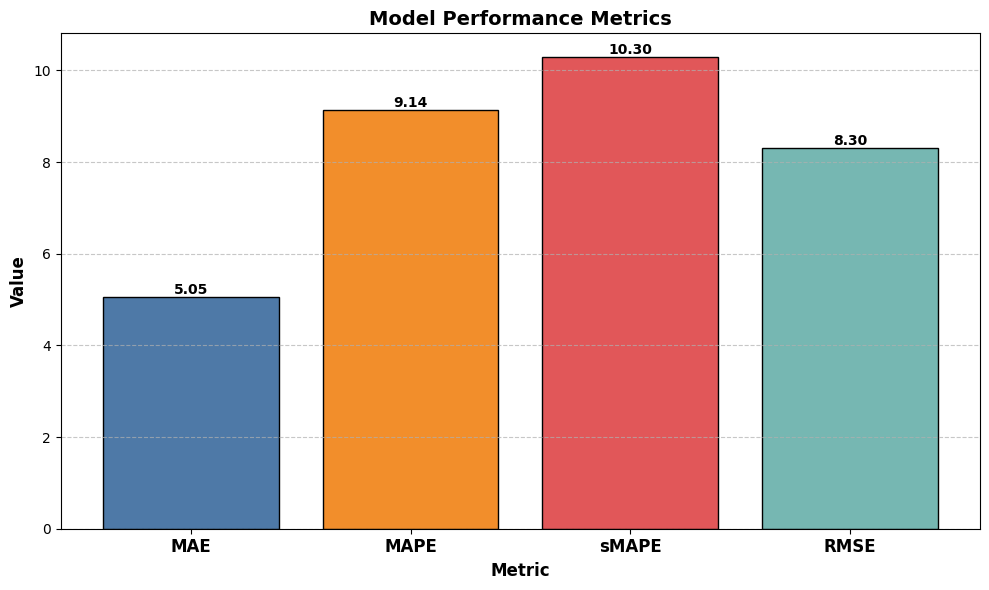

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Metric names
metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']

x_pos = np.arange(len(metrics_names))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, test_metrics, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')

# Adding the metric names as labels on the x-axis
plt.xticks(x_pos, metrics_names, fontsize=12, fontweight='bold')

# Adding a title and labels for the axes
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')

# Adding the value of each metric above its bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# n_lags is the number of lagged periods used
n_lags = 3

# Function to check if the first 'n_lags' of the current dataset
def check_overlap(previous_df, current_df, target_column, n_lags):
    overlap = False
    if previous_df[target_column].tail(n_lags).equals(current_df[target_column].head(n_lags)):
        overlap = True
    return overlap

# Checking for overlap between training and validation
train_validation_overlap = check_overlap(train_df, validation_df, 'MW', n_lags)

# Checking for overlap between validation and test
validation_test_overlap = check_overlap(validation_df, test_df, 'MW', n_lags)

# results
print(f"Overlap between train and validation datasets: {train_validation_overlap}")
print(f"Overlap between validation and test datasets: {validation_test_overlap}")


Overlap between train and validation datasets: False
Overlap between validation and test datasets: False
